In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from scipy.stats import norm, multivariate_normal
from scipy.spatial.distance import cdist
import ot  # POT library
from tqdm import tqdm

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)

print("Imports successful!")

Imports successful!


In [3]:
class RandomMeasure:
    """
    Represents a random probability measure M: Omega -> P_2(R^d)
    
    Parameters:
    -----------
    n_components : int
        Number of realizations |Omega|
    n_particles : int
        Number of particles per realization
    dim : int
        Dimension of the space
    weights : array-like, optional
        Weights w_k for each component (sums to 1)
    """
    
    def __init__(self, n_components, n_particles, dim, weights=None):
        self.n_components = n_components
        self.n_particles = n_particles
        self.dim = dim
        
        # Weights for each component
        if weights is None:
            self.weights = np.ones(n_components) / n_components
        else:
            self.weights = np.array(weights)
            self.weights = self.weights / self.weights.sum()
        
        # Particles: shape (n_components, n_particles, dim)
        self.particles = np.zeros((n_components, n_particles, dim))
        
        # Uniform weights for particles within each component
        self.particle_weights = np.ones(n_particles) / n_particles
    
    def initialize_from_distribution(self, sample_fn):
        """
        Initialize particles from a sampling function.
        
        Parameters:
        -----------
        sample_fn : callable
            Function with signature sample_fn(omega, n_samples) -> array of shape (n_samples, dim)
        """
        for omega in range(self.n_components):
            self.particles[omega] = sample_fn(omega, self.n_particles)
    
    def initialize_from_gmm(self, means, covs):
        """
        Initialize from Gaussian mixture.
        
        Parameters:
        -----------
        means : array-like, shape (n_components, dim)
        covs : array-like, shape (n_components, dim, dim)
        """
        means = np.array(means)
        covs = np.array(covs)
        
        for omega in range(self.n_components):
            self.particles[omega] = np.random.multivariate_normal(
                means[omega], covs[omega], size=self.n_particles
            )
    
    def get_component(self, omega):
        """Get particles for a specific component."""
        return self.particles[omega]
    
    def __repr__(self):
        return f"RandomMeasure(n_components={self.n_components}, n_particles={self.n_particles}, dim={self.dim})"

In [4]:
class TargetDistribution:
    """
    Represents a target distribution pi on R^d.
    Can be a mixture or any distribution with evaluable log density.
    """
    
    def __init__(self, log_density_fn, gradient_log_density_fn, name="Target"):
        """
        Parameters:
        -----------
        log_density_fn : callable
            Function x -> log(pi(x)), shape (n_samples, dim) -> (n_samples,)
        gradient_log_density_fn : callable
            Function x -> grad log(pi(x)), shape (n_samples, dim) -> (n_samples, dim)
        name : str
            Name for plotting
        """
        self.log_density = log_density_fn
        self.grad_log_density = gradient_log_density_fn
        self.name = name
    
    def sample(self, n_samples):
        """Override this for specific distributions."""
        raise NotImplementedError("Sampling not implemented for generic target")
    
    @classmethod
    def from_gmm(cls, weights, means, covs, name="GMM"):
        """
        Create target from Gaussian Mixture Model.
        
        Parameters:
        -----------
        weights : array-like, shape (n_modes,)
        means : array-like, shape (n_modes, dim)
        covs : array-like, shape (n_modes, dim, dim)
        """
        weights = np.array(weights)
        weights = weights / weights.sum()
        means = np.array(means)
        covs = np.array(covs)
        n_modes = len(weights)
        dim = means.shape[1]
        
        # Create multivariate normal objects
        mvns = [multivariate_normal(means[j], covs[j]) for j in range(n_modes)]
        
        def log_density_fn(x):
            """Compute log density using log-sum-exp trick."""
            # x shape: (n_samples, dim)
            log_probs = np.zeros((x.shape[0], n_modes))
            for j in range(n_modes):
                log_probs[:, j] = np.log(weights[j]) + mvns[j].logpdf(x)
            
            # Log-sum-exp
            max_log = np.max(log_probs, axis=1, keepdims=True)
            return max_log.squeeze() + np.log(np.sum(np.exp(log_probs - max_log), axis=1))
        
        def gradient_log_density_fn(x):
            """Compute gradient of log density."""
            # x shape: (n_samples, dim)
            n_samples = x.shape[0]
            
            # Compute responsibilities
            log_probs = np.zeros((n_samples, n_modes))
            for j in range(n_modes):
                log_probs[:, j] = np.log(weights[j]) + mvns[j].logpdf(x)
            
            # Normalize (responsibilities)
            max_log = np.max(log_probs, axis=1, keepdims=True)
            log_probs_norm = log_probs - max_log
            responsibilities = np.exp(log_probs_norm)
            responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
            
            # Gradient is weighted sum of gradients toward each mode
            grad = np.zeros((n_samples, dim))
            for j in range(n_modes):
                # Gradient of log N(mu_j, Sigma_j) is -Sigma_j^{-1}(x - mu_j)
                inv_cov = np.linalg.inv(covs[j])
                grad_j = -np.dot(x - means[j], inv_cov.T)
                grad += responsibilities[:, j:j+1] * grad_j
            
            return grad
        
        def sample_fn(n_samples):
            """Sample from the GMM."""
            # Sample components
            components = np.random.choice(n_modes, size=n_samples, p=weights)
            samples = np.zeros((n_samples, dim))
            for j in range(n_modes):
                mask = components == j
                n_j = mask.sum()
                if n_j > 0:
                    # Sample from this component
                    samples_j = mvns[j].rvs(size=n_j)
                    # Handle 1D case where rvs returns shape (n,) instead of (n, 1)
                    if dim == 1 and samples_j.ndim == 1:
                        samples_j = samples_j.reshape(-1, 1)
                    samples[mask] = samples_j
            return samples
        
        target = cls(log_density_fn, gradient_log_density_fn, name=name)
        target.sample = sample_fn
        target.means = means
        target.covs = covs
        target.weights = weights
        target.dim = dim  # Store dimension
        return target

In [5]:
class LiftedWassersteinGradientFlow:
    """
    Implements gradient flow on the space of random measures.
    """
    
    def __init__(self, random_measure, target, tau=0.01):
        """
        Parameters:
        -----------
        random_measure : RandomMeasure
        target : TargetDistribution
        tau : float
            Time step size
        """
        self.M = random_measure
        self.target = target
        self.tau = tau
        
        # History for tracking
        self.history = {
            'loss': [],
            'component_distances': [],
            'particles': [],
            'iterations': []
        }
    
    def compute_kl_divergence(self, omega):
        """
        Compute KL(M(omega) || pi) using particles.
        This is approximate - we use the empirical distribution.
        """
        particles = self.M.particles[omega]
        
        # Log density under target
        log_pi = self.target.log_density(particles)
        
        # Empirical entropy (using uniform weights for particles)
        # H(M(omega)) ≈ -mean(log p_empirical)
        # For uniform weights, this is just log(n_particles)
        # KL ≈ -H(M) - E[log pi]
        
        kl_approx = -np.mean(log_pi) - np.log(self.M.n_particles)
        return kl_approx
    
    def compute_lifted_loss(self):
        """
        Compute E[KL(M(omega) || pi)] over all components.
        """
        kl_values = np.array([self.compute_kl_divergence(omega) 
                              for omega in range(self.M.n_components)])
        return np.sum(self.M.weights * kl_values)
    
    def compute_wasserstein_distance(self, omega):
        """
        Compute W_2(M(omega), pi) using POT.
        """
        # Get particles for this component
        particles_omega = self.M.particles[omega]
        
        # Sample from target
        target_samples = self.target.sample(self.M.n_particles)
        
        # Compute cost matrix (squared Euclidean distance)
        C = cdist(particles_omega, target_samples, metric='sqeuclidean')
        
        # Solve OT problem
        a = self.M.particle_weights
        b = np.ones(self.M.n_particles) / self.M.n_particles
        
        # Compute Wasserstein distance
        w2_squared = ot.emd2(a, b, C, numItermax=1e6)
        
        return np.sqrt(w2_squared)
    
    def compute_lifted_distance(self):
        """
        Compute d(M, pi) = sqrt(E[W_2^2(M(omega), pi)]).
        """
        w2_values = np.array([self.compute_wasserstein_distance(omega) 
                              for omega in range(self.M.n_components)])
        return np.sqrt(np.sum(self.M.weights * w2_values**2))
    
    def langevin_step(self, omega):
        """
        Perform one Langevin dynamics step for component omega.
        
        Updates: X_{i+1} = X_i + tau * grad_log_pi(X_i) + sqrt(2*tau) * noise
        """
        particles = self.M.particles[omega]
        
        # Compute drift (gradient of log target)
        drift = self.target.grad_log_density(particles)
        
        # Compute diffusion (Gaussian noise)
        noise = np.random.randn(self.M.n_particles, self.M.dim)
        
        # Langevin update
        self.M.particles[omega] = particles + self.tau * drift + np.sqrt(2 * self.tau) * noise
    
    def step(self):
        """
        Perform one gradient flow step for all components.
        """
        # Update all components in parallel (sequentially in code, but conceptually parallel)
        for omega in range(self.M.n_components):
            self.langevin_step(omega)
    
    def run(self, n_iterations, save_every=10, compute_distances=False, verbose=True):
        """
        Run the gradient flow.
        
        Parameters:
        -----------
        n_iterations : int
        save_every : int
            Save history every this many iterations
        compute_distances : bool
            Whether to compute Wasserstein distances (expensive)
        verbose : bool
            Whether to print progress
        """

        
        for it in tqdm(range(n_iterations), desc = 'RMSGD Steps'):
            # Perform step
            self.step()
            
            # Save history
            if it % save_every == 0:
                loss = self.compute_lifted_loss()
                self.history['loss'].append(loss)
                self.history['iterations'].append(it)
                
                if compute_distances:
                    distances = [self.compute_wasserstein_distance(omega) 
                                for omega in range(self.M.n_components)]
                    self.history['component_distances'].append(distances)
                
                # Save particle snapshots (only for small examples)
                self.history['particles'].append(self.M.particles.copy())
        
        if verbose:
            print()  # New line after progress

In [6]:
def plot_loss_curve(history):
    """Plot the loss E[KL(M(omega) || pi)] over iterations."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.plot(history['iterations'], history['loss'], linewidth=2)
    ax.set_xlabel('Iteration', fontsize=14)
    ax.set_ylabel(r'$\mathcal{E}(M) = \mathbb{E}[\mathrm{KL}(M(\omega) \| \pi)]$', fontsize=14)
    ax.set_title('Lifted Wasserstein Gradient Flow: Loss over Time', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_component_distances(history, weights):
    """Plot W_2(M(omega), pi) for each component."""
    if not history['component_distances']:
        print("No distance history available. Run with compute_distances=True")
        return
    
    distances = np.array(history['component_distances'])  # shape: (n_saves, n_components)
    iterations = history['iterations']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Individual component distances
    ax = axes[0]
    n_components = distances.shape[1]
    for omega in range(n_components):
        ax.plot(iterations, distances[:, omega], label=f'ω={omega}', alpha=0.7)
    
    ax.set_xlabel('Iteration', fontsize=14)
    ax.set_ylabel(r'$W_2(M(\omega), \pi)$', fontsize=14)
    ax.set_title('Wasserstein Distance per Component', fontsize=16)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Lifted distance
    ax = axes[1]
    # Fix: weights should be shape (n_components,) and distances is (n_saves, n_components)
    # We want to compute sum over components for each time point
    lifted_dist = np.sqrt(np.sum(weights[None, :] * distances**2, axis=1))
    ax.plot(iterations, lifted_dist, linewidth=2, color='red')
    ax.set_xlabel('Iteration', fontsize=14)
    ax.set_ylabel(r'$d(M, \delta_\pi) = \sqrt{\mathbb{E}[W_2^2(M(\omega), \pi)]}$', fontsize=14)
    ax.set_title('Lifted Wasserstein Distance', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_particles_1d(M, target, iteration=None, n_bins=50):
    """
    Plot particle distributions for 1D case.
    """
    if M.dim != 1:
        print("This function is for 1D distributions only")
        return
    
    n_components = M.n_components
    n_cols = min(4, n_components)
    n_rows = (n_components + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_components == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Get range for plotting
    all_particles = M.particles.reshape(-1, 1)
    x_min, x_max = all_particles.min() - 1, all_particles.max() + 1
    x_range = np.linspace(x_min, x_max, 200).reshape(-1, 1)
    
    # Compute target density
    log_target = target.log_density(x_range)
    target_density = np.exp(log_target)
    # Use trapezoid instead of trapz (deprecated)
    target_density = target_density / np.trapezoid(target_density, x_range.squeeze())
    
    for omega in range(n_components):
        ax = axes[omega]
        
        # Plot histogram of particles
        particles = M.particles[omega].squeeze()
        ax.hist(particles, bins=n_bins, density=True, alpha=0.6, 
                color=f'C{omega}', label=f'M({omega})')
        
        # Plot target
        ax.plot(x_range, target_density, 'k--', linewidth=2, label='Target π')
        
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_title(f'Component ω={omega}', fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_components, len(axes)):
        axes[idx].axis('off')
    
    title = f'Random Measure Distributions'
    if iteration is not None:
        title += f' (Iteration {iteration})'
    fig.suptitle(title, fontsize=16, y=1.00)
    
    plt.tight_layout()
    return fig

def plot_particles_2d(M, target, iteration=None, n_levels=10):
    """
    Plot particle distributions for 2D case.
    """
    if M.dim != 2:
        print("This function is for 2D distributions only")
        return
    
    n_components = min(M.n_components, 9)  # Limit to 9 for visualization
    n_cols = min(3, n_components)
    n_rows = (n_components + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    if n_components == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Get range for plotting
    all_particles = M.particles[:n_components].reshape(-1, 2)
    x_min, x_max = all_particles[:, 0].min() - 1, all_particles[:, 0].max() + 1
    y_min, y_max = all_particles[:, 1].min() - 1, all_particles[:, 1].max() + 1
    
    # Create grid for target density
    x_grid = np.linspace(x_min, x_max, 100)
    y_grid = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    grid_points = np.column_stack([X.ravel(), Y.ravel()])
    
    log_target = target.log_density(grid_points)
    Z = np.exp(log_target).reshape(X.shape)
    
    for omega in range(n_components):
        ax = axes[omega]
        
        # Plot target as contours
        contour = ax.contour(X, Y, Z, levels=n_levels, colors='black', 
                            alpha=0.3, linewidths=1)
        ax.contourf(X, Y, Z, levels=n_levels, cmap='Greys', alpha=0.2)
        
        # Plot particles
        particles = M.particles[omega]
        ax.scatter(particles[:, 0], particles[:, 1], 
                  c=f'C{omega}', alpha=0.5, s=10, label=f'M({omega})')
        
        ax.set_xlabel('$x_1$', fontsize=12)
        ax.set_ylabel('$x_2$', fontsize=12)
        ax.set_title(f'Component ω={omega}', fontsize=14)
        ax.legend(fontsize=10)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_components, len(axes)):
        axes[idx].axis('off')
    
    title = f'Random Measure Distributions (2D)'
    if iteration is not None:
        title += f' (Iteration {iteration})'
    fig.suptitle(title, fontsize=16, y=0.995)
    
    plt.tight_layout()
    return fig

# 1D Random Measure

In [7]:
print("="*60)
print("EXAMPLE 1: 1D Random Gaussian Mixture → Bimodal Target")
print("="*60)

# Problem setup
n_components = 5
n_particles = 1000
dim = 1

# Create random measure: Each component starts as N(0, 4)
M = RandomMeasure(n_components, n_particles, dim)
# use random initial means and large variance to ensure they are spread out
initial_means = np.random.randn(n_components, dim) * 2.0  # Spread out around 0
initial_covs = np.array([[[4.0]] for _ in range(n_components)])
M.initialize_from_gmm(initial_means, initial_covs)

# Create target: Bimodal Gaussian mixture
target = TargetDistribution.from_gmm(
    weights=[0.5, 0.5],
    means=[[-2.0], [2.0]],
    covs=[[[1.0]], [[1.0]]],
    name="Bimodal GMM"
)

print(f"\nRandom Measure: {n_components} components, {n_particles} particles each")
print(f"Target: Bimodal Gaussian mixture")
print(f"Initial: All components start at N(0, 4)")

EXAMPLE 1: 1D Random Gaussian Mixture → Bimodal Target

Random Measure: 5 components, 1000 particles each
Target: Bimodal Gaussian mixture
Initial: All components start at N(0, 4)


In [8]:
# Create solver
tau = 0.001
solver = LiftedWassersteinGradientFlow(M, target, tau=tau)

print(f"\nRunning gradient flow with tau = {tau}...")

# Run
n_iterations = 10000
solver.run(n_iterations, save_every=20, compute_distances=True)

print(f"\n  Gradient flow complete!")
print(f"  Initial loss: {solver.history['loss'][0]:.4f}")
print(f"  Final loss: {solver.history['loss'][-1]:.4f}")


Running gradient flow with tau = 0.001...


RMSGD Steps: 100%|██████████| 10000/10000 [02:02<00:00, 81.92it/s]



  Gradient flow complete!
  Initial loss: -4.1652
  Final loss: -4.8520


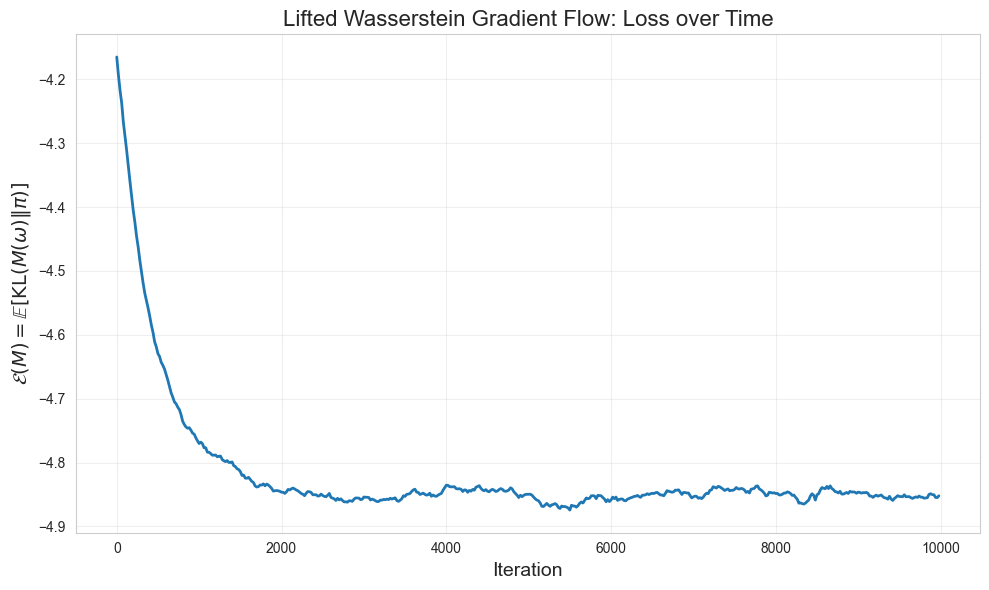

In [9]:
fig = plot_loss_curve(solver.history)
plt.show()

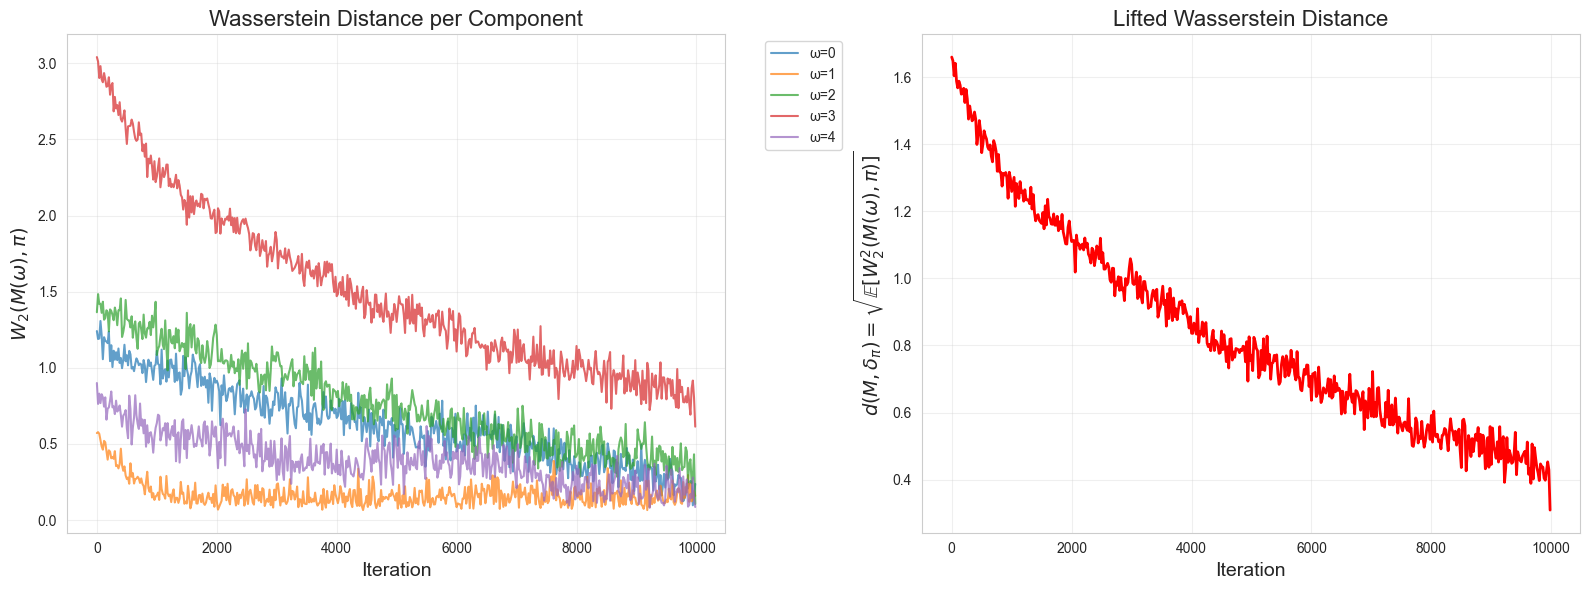

In [10]:
fig = plot_component_distances(solver.history, M.weights)
plt.show()

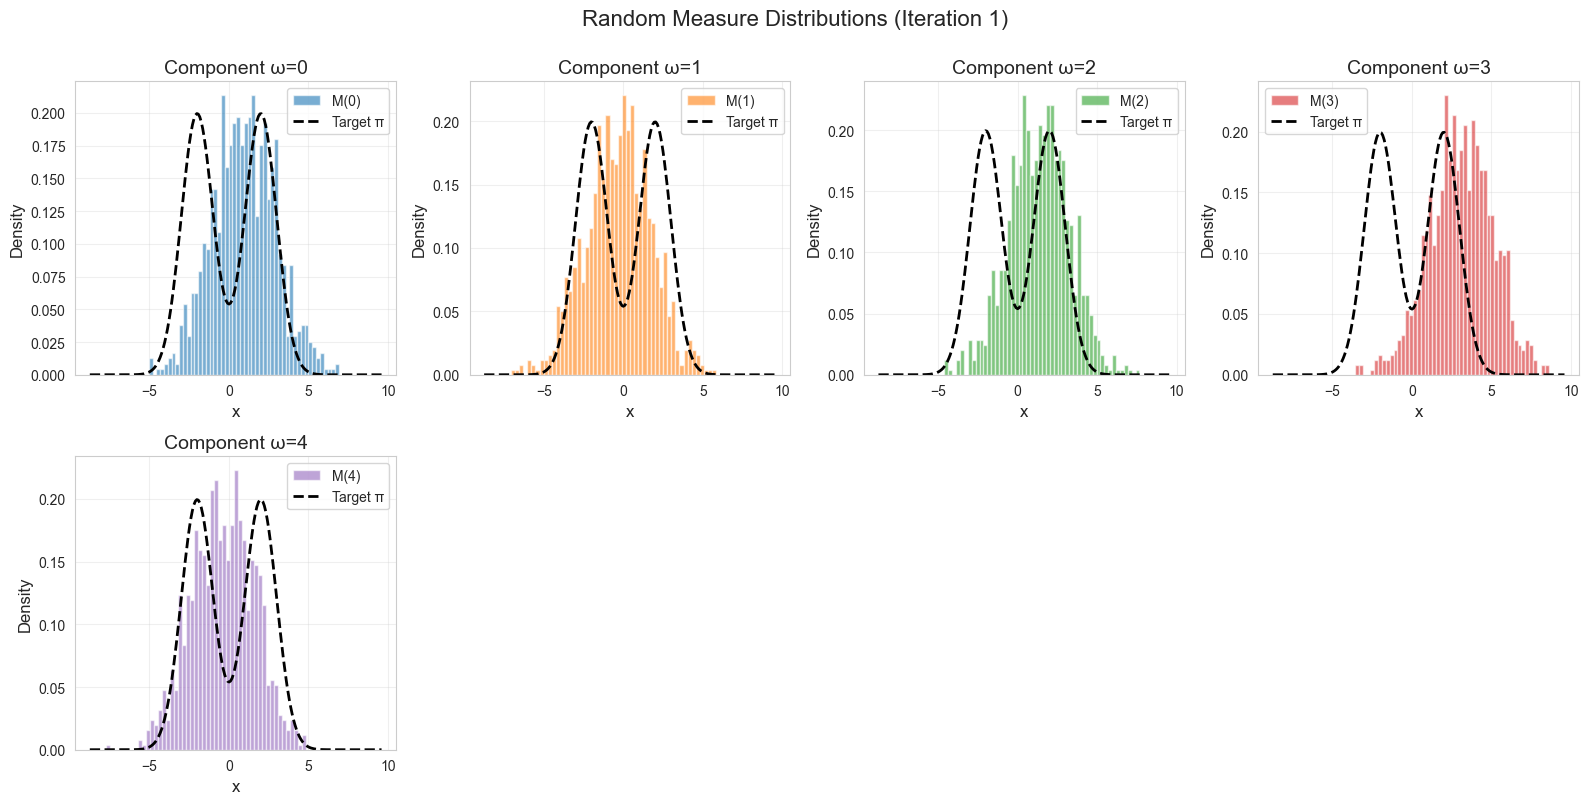

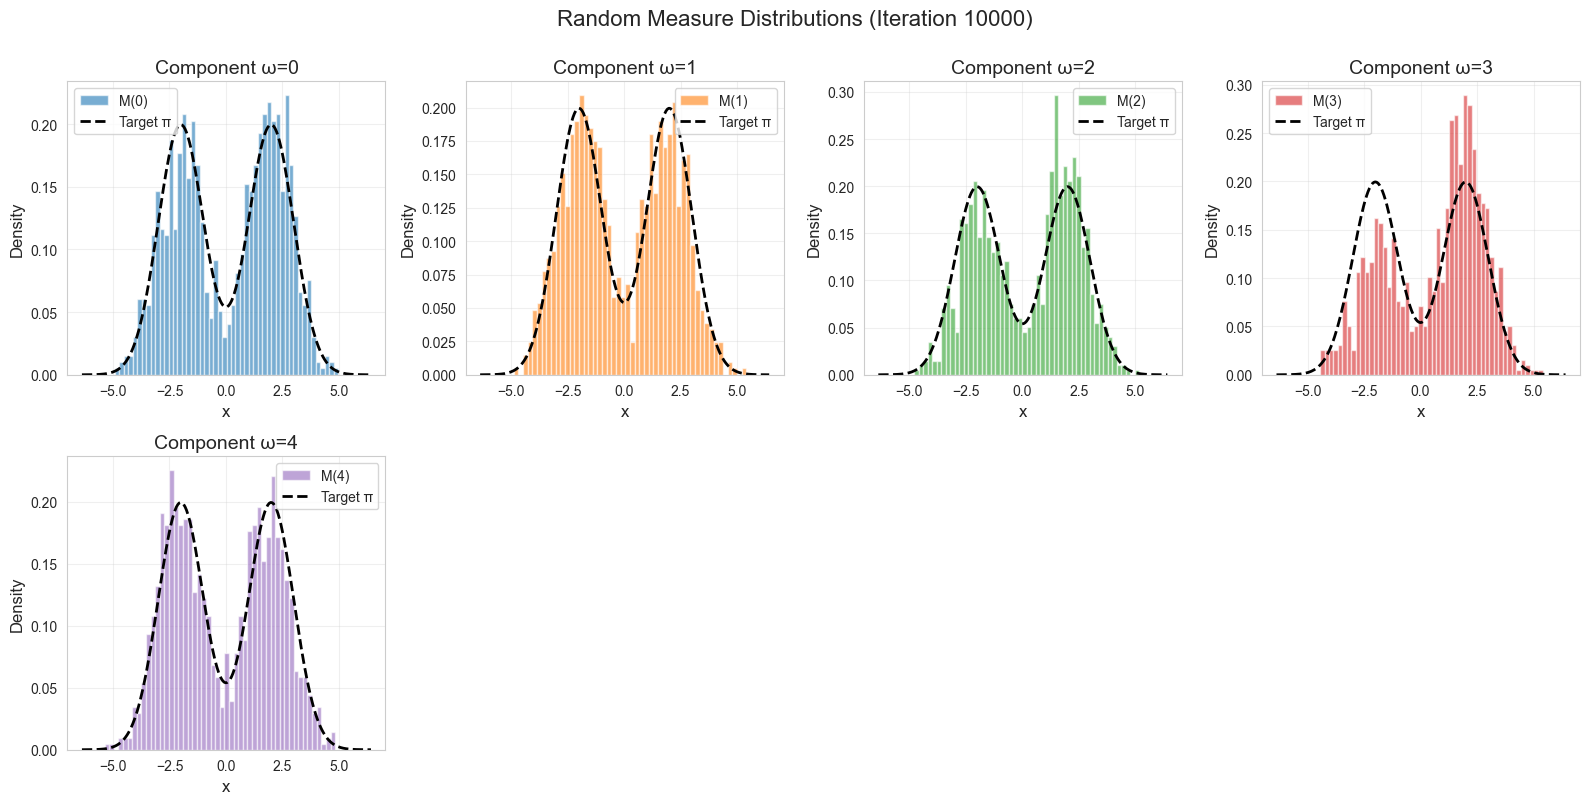

In [11]:
# Re-initialize to show initial state
M_initial = RandomMeasure(n_components, n_particles, dim)
M_initial.initialize_from_gmm(initial_means, initial_covs)
fig_initial = plot_particles_1d(M_initial, target, iteration=1)
plt.show()

fig_final = plot_particles_1d(M, target, iteration=n_iterations)
plt.show()

# 2D Random Measure

In [12]:
print("\n" + "="*60)
print("EXAMPLE 2: 2D Random Gaussian Mixture → Complex Target")
print("="*60)

# Problem setup
n_components_2d = 6
n_particles_2d = 5000
dim_2d = 2

# Create random measure: Each component starts at different location
M_2d = RandomMeasure(n_components_2d, n_particles_2d, dim_2d)
initial_means_2d = np.random.randn(n_components_2d, dim_2d) * 3
initial_covs_2d = np.array([np.eye(dim_2d) * 2 for _ in range(n_components_2d)])
M_2d.initialize_from_gmm(initial_means_2d, initial_covs_2d)

# Create target: 4-mode Gaussian mixture in a square pattern
target_2d = TargetDistribution.from_gmm(
    weights=np.array([0.25, 0.25, 0.25, 0.25]),
    means=[[-2, -2], [-2, 2], [2, -2], [2, 2]],
    covs=[np.eye(2) * 0.5 for _ in range(4)],
    name="4-mode GMM"
)

print(f"\nRandom Measure: {n_components_2d} components, {n_particles_2d} particles each (2D)")
print(f"Target: 4-mode Gaussian mixture at corners of square")
print(f"Initial: Components start at random locations")


EXAMPLE 2: 2D Random Gaussian Mixture → Complex Target

Random Measure: 6 components, 5000 particles each (2D)
Target: 4-mode Gaussian mixture at corners of square
Initial: Components start at random locations


In [13]:
tau_2d = 0.01
solver_2d = LiftedWassersteinGradientFlow(M_2d, target_2d, tau=tau_2d)

print(f"\nRunning 2D gradient flow with tau = {tau_2d}...")
n_iterations_2d = 5000
solver_2d.run(n_iterations_2d, save_every=30, compute_distances=False)

print(f"\n 2D Gradient flow complete")
print(f"  Initial loss: {solver_2d.history['loss'][0]:.4f}")
print(f"  Final loss: {solver_2d.history['loss'][-1]:.4f}")


Running 2D gradient flow with tau = 0.01...


RMSGD Steps: 100%|██████████| 5000/5000 [00:46<00:00, 107.59it/s]



 2D Gradient flow complete
  Initial loss: 1.1433
  Final loss: -4.9886


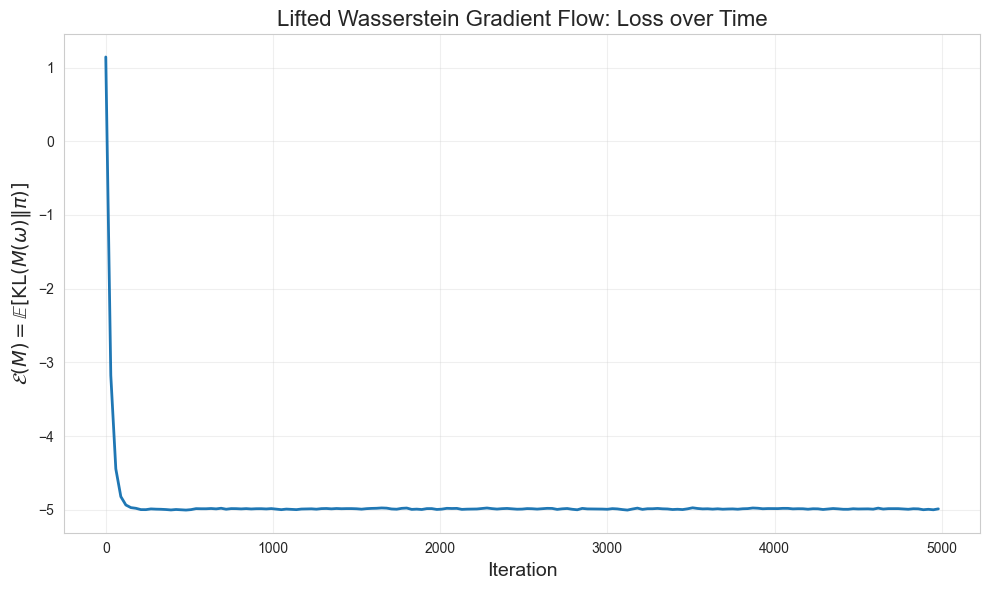

In [14]:
fig = plot_loss_curve(solver_2d.history)
plt.show()

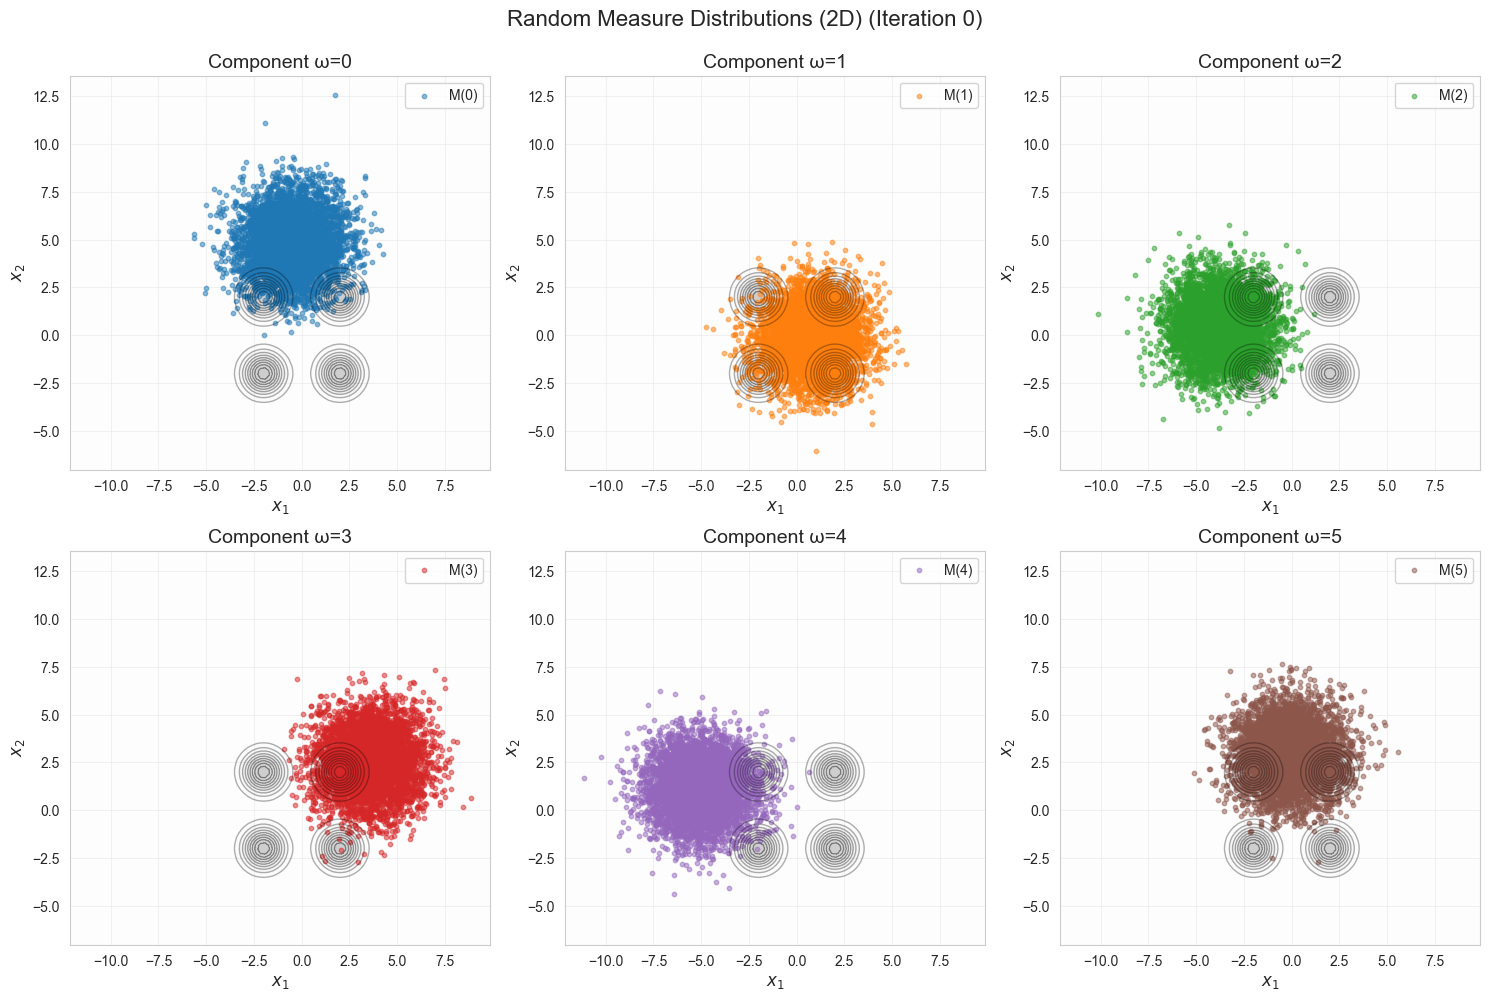

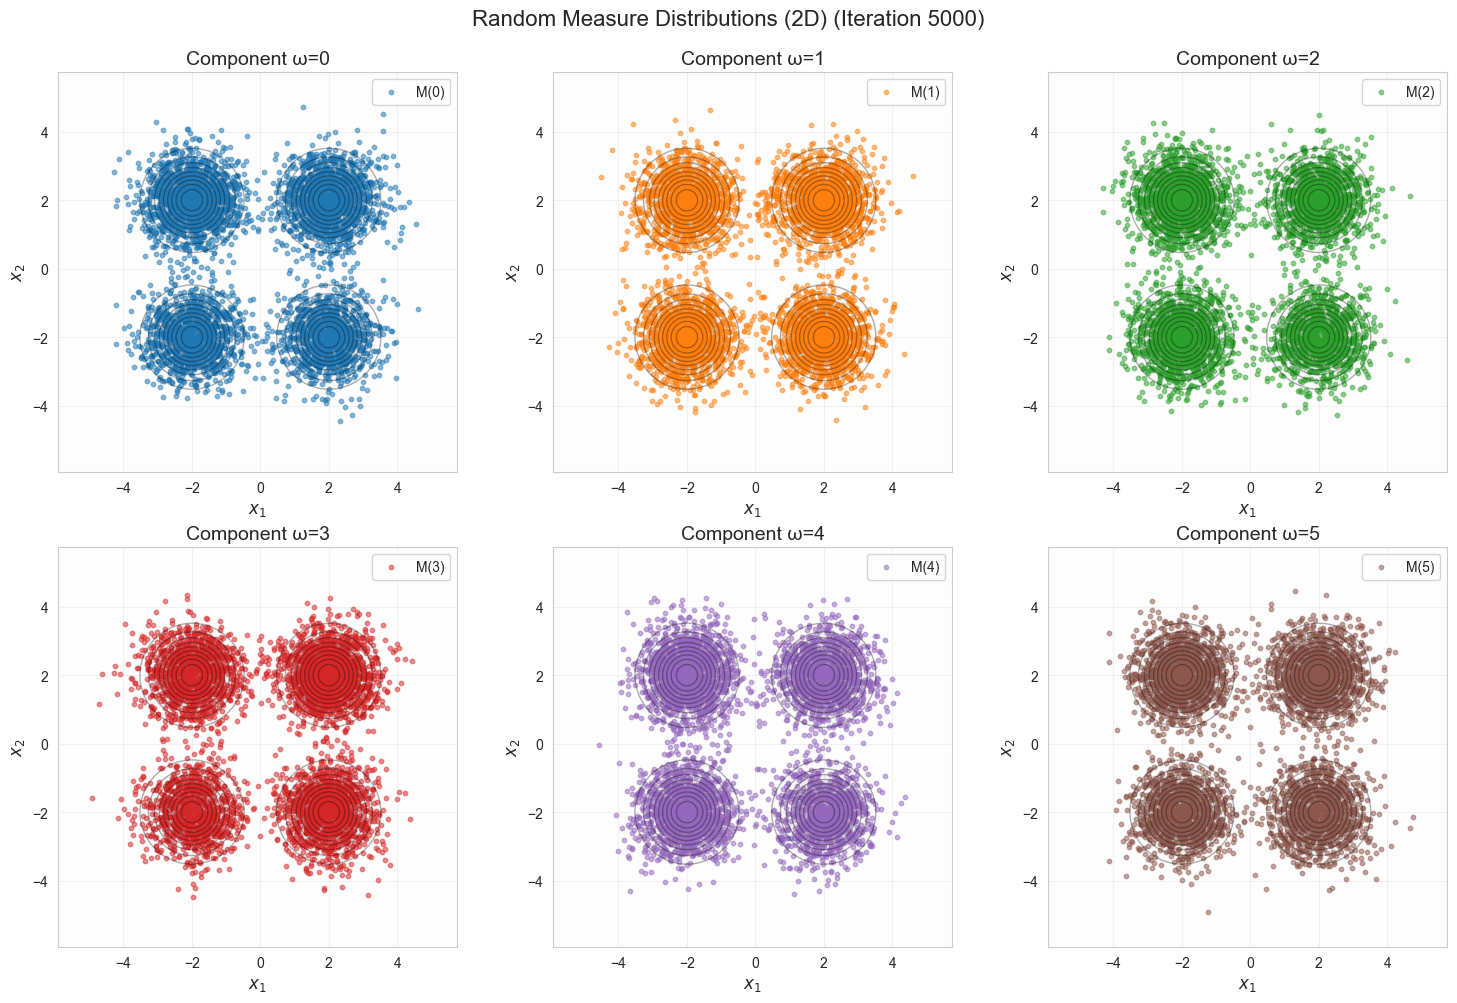

In [15]:
M_2d_initial = RandomMeasure(n_components_2d, n_particles_2d, dim_2d)
M_2d_initial.initialize_from_gmm(initial_means_2d, initial_covs_2d)
fig = plot_particles_2d(M_2d_initial, target_2d, iteration=0)
fig = plot_particles_2d(M_2d, target_2d, iteration=n_iterations_2d)